In [1]:
# import bertopic
# Data processing
import pandas as pd
import numpy as np# Text preprocessiong
import nltk
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')
wn = nltk.WordNetLemmatizer()# Topic model
from bertopic import BERTopic# Dimension reduction
from umap import UMAP

C:\Users\BK\anaconda3\envs\NLP_2\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\BK\anaconda3\envs\NLP_2\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\BK\anaconda3\envs\NLP_2\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarni

In [2]:
df=pd.read_excel(r"Final_Data\Data.xlsx")

## WORKING GRAPH

In [3]:
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

# Function to check for special characters
def has_special_characters(word):
    return any(char in word for char in "!@#$%^&*()_-+=<>?,./;:[]{}|\\")



def graph_net(df):



    df_test = df['review_lemmatized']

    # Load the spaCy model
    nlp = spacy.load("en_core_web_sm")

    # Create dictionaries to store the counts of nouns, verbs, and adjectives
    noun_counts = defaultdict(int)
    verb_counts = defaultdict(int)
    adjective_counts = defaultdict(int)

    # Create a co-occurrence matrix for nouns, verbs, and adjectives
    co_occurrence_matrix = defaultdict(lambda: defaultdict(int))

    # Process each title and count nouns, verbs, and adjectives
    for title in df_test:
        if isinstance(title, str):
            doc = nlp(title)
        else:
            continue
        title_str = str(title)
        doc = nlp(title)
        nouns = [token.text for token in doc if token.pos_ == 'NOUN' and not has_special_characters(token.text)]
        verbs = [token.text for token in doc if token.pos_ == 'VERB' and not has_special_characters(token.text)]
        adjectives = [token.text for token in doc if token.pos_ == 'ADJ' and not has_special_characters(token.text)]

        for noun in nouns:
            noun_counts[noun] += 1
        for verb in verbs:
            verb_counts[verb] += 1
        for adjective in adjectives:
            adjective_counts[adjective] += 1

        # Construct co-occurrence matrix for noun-verb-adjective connections
        for noun in nouns:
            for verb in verbs:
                co_occurrence_matrix[noun][verb] += 1
        for noun in nouns:
            for adjective in adjectives:
                co_occurrence_matrix[noun][adjective] += 1
        for verb in verbs:
            for adjective in adjectives:
                co_occurrence_matrix[verb][adjective] += 1

    # Create a graph network
    G = nx.Graph()

    # Add nodes (nouns, verbs, and adjectives) with different colors
    for word, count in noun_counts.items():
        G.add_node(word, count=count, pos='NOUN', color='lightblue')
    for word, count in verb_counts.items():
        G.add_node(word, count=count, pos='VERB', color='green')
    for word, count in adjective_counts.items():
        G.add_node(word, count=count, pos='ADJ', color='red')

    # Add edges (co-occurrence relationships between nouns, verbs, and adjectives)
    for noun, cooccur in co_occurrence_matrix.items():
        for word, count in cooccur.items():
            # Ensure that connections are only between different types of nodes
            if G.nodes[noun]['pos'] != G.nodes[word]['pos']:
                G.add_edge(noun, word, weight=count)

    # Select the top 50 nodes by degree
    # top_nodes = sorted(G.nodes, key=lambda node: -G.degree(node))
    top_nodes = sorted(G.nodes, key=lambda node: -G.degree(node))[:50]

    # Create a subgraph with the top nodes
    H = G.subgraph(top_nodes)

    # Check and remove isolated nodes from the subgraph by creating a copy
    isolated_nodes = [node for node in H.nodes if H.degree(node) == 0]
    H_copy = H.copy()
    H_copy.remove_nodes_from(isolated_nodes)

    # Use Kamada-Kawai layout to achieve better node positioning for the copy
    pos = nx.kamada_kawai_layout(H_copy)

    # Plot the subgraph with different node colors
    node_colors = [H.nodes[node]['color'] for node in H_copy]

    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(H_copy, pos, node_size=200, node_color=node_colors)
    nx.draw_networkx_edges(H_copy, pos, edge_color='gray', alpha=0.7)
    nx.draw_networkx_labels(H_copy, pos, font_size=8, font_color='black', font_weight='bold')
    plt.axis('off')
    plt.title("Co-occurrence Network of Top 50 Nouns, Verbs, and Adjectives in Titles")
    plt.show()
    return G.nodes(data=True),G.edges(data=True)


In [15]:
def node_data(raw_data,topic):
    nodes_df = pd.DataFrame(columns=["id", "count", "pos", "color",'topic'])
    for node, data in raw_data:
        nodes_df = pd.concat([nodes_df, pd.DataFrame([{
            "id": node,
            "count": data["count"],
            "pos": data["pos"],
            "color": data["color"],
            "topic": topic
        }])], ignore_index=True)
    return nodes_df

In [16]:
def edge_data(raw_data,topic):
    edges_df = pd.DataFrame(columns=["source", "target", "weight",'topic'])
    for source, target, data in raw_data:
        edges_df = pd.concat([edges_df, pd.DataFrame([{
            "source": source,
            "target": target,
            "weight": data["weight"],
            "topic": topic

        }])], ignore_index=True)
    return edges_df

In [17]:
def all_topics(df): 
    edge_df=pd.DataFrame(columns=["source", "target", "weight",'topic'])
    node_df=pd.DataFrame(columns=["id", "count", "pos", "color",'topic'])
    num_topics=len(df.topic.unique())
    for topic in range(num_topics):
        topic_data=df[df.topic==topic].reset_index()
        nodes,edges=graph_net(topic_data)
        
        edge_topic_data=edge_data(edges,topic)
        edge_df=pd.concat([edge_df,edge_topic_data])
        
        node_topic_data=node_data(nodes,topic)
        node_df=pd.concat([node_df,node_topic_data])
        
    return node_df,edge_df


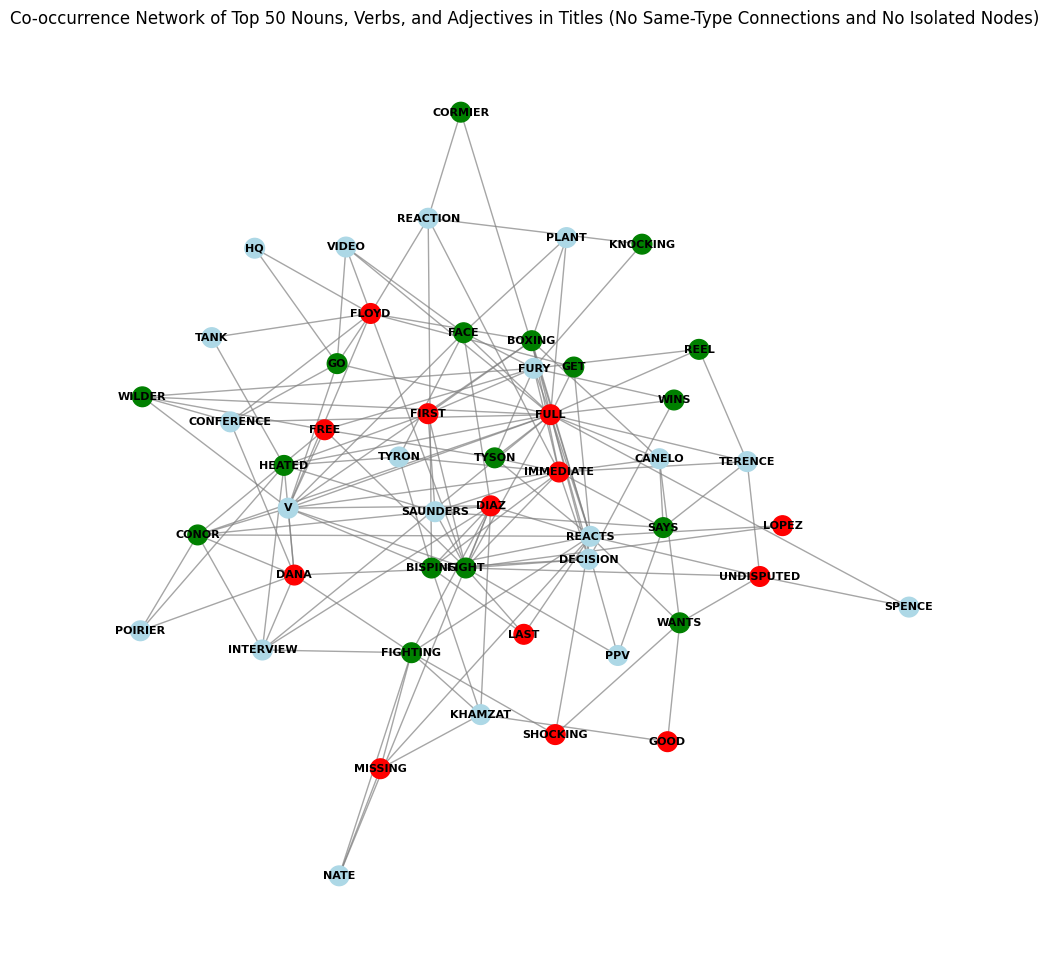

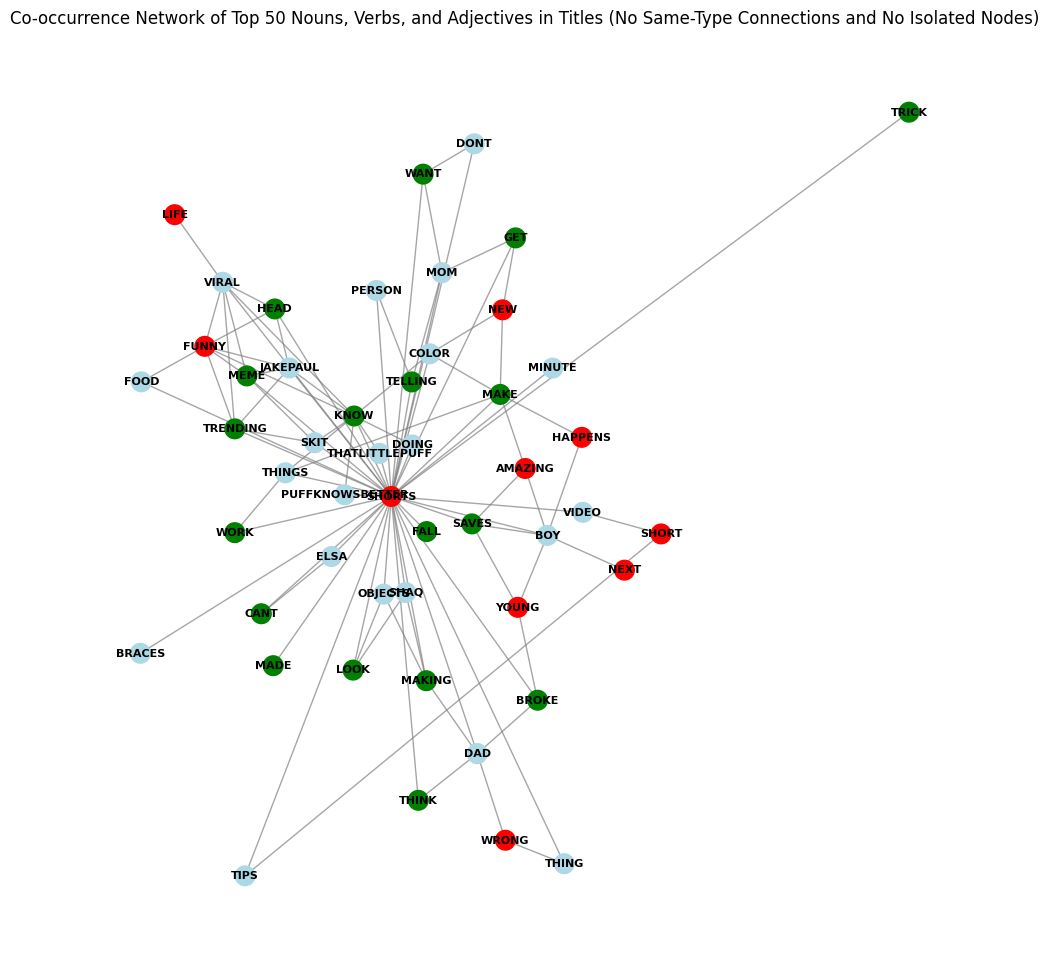

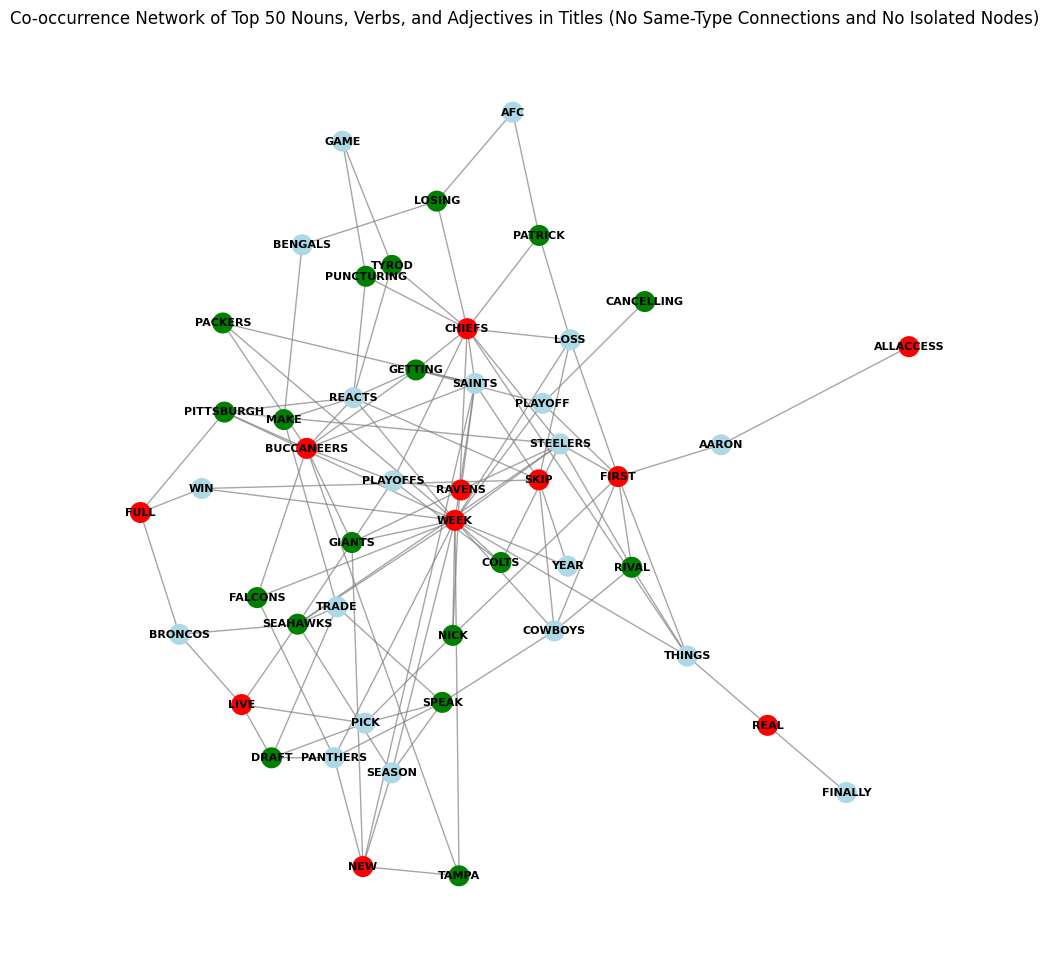

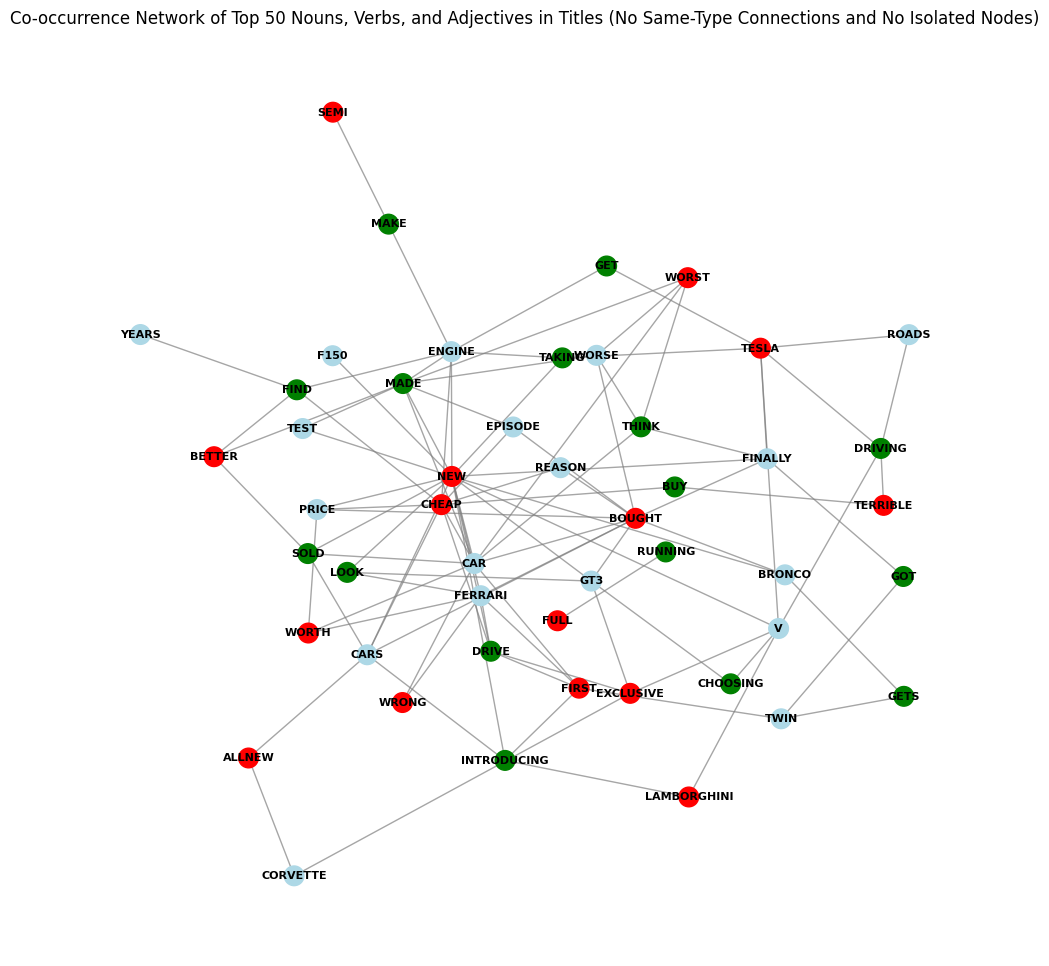

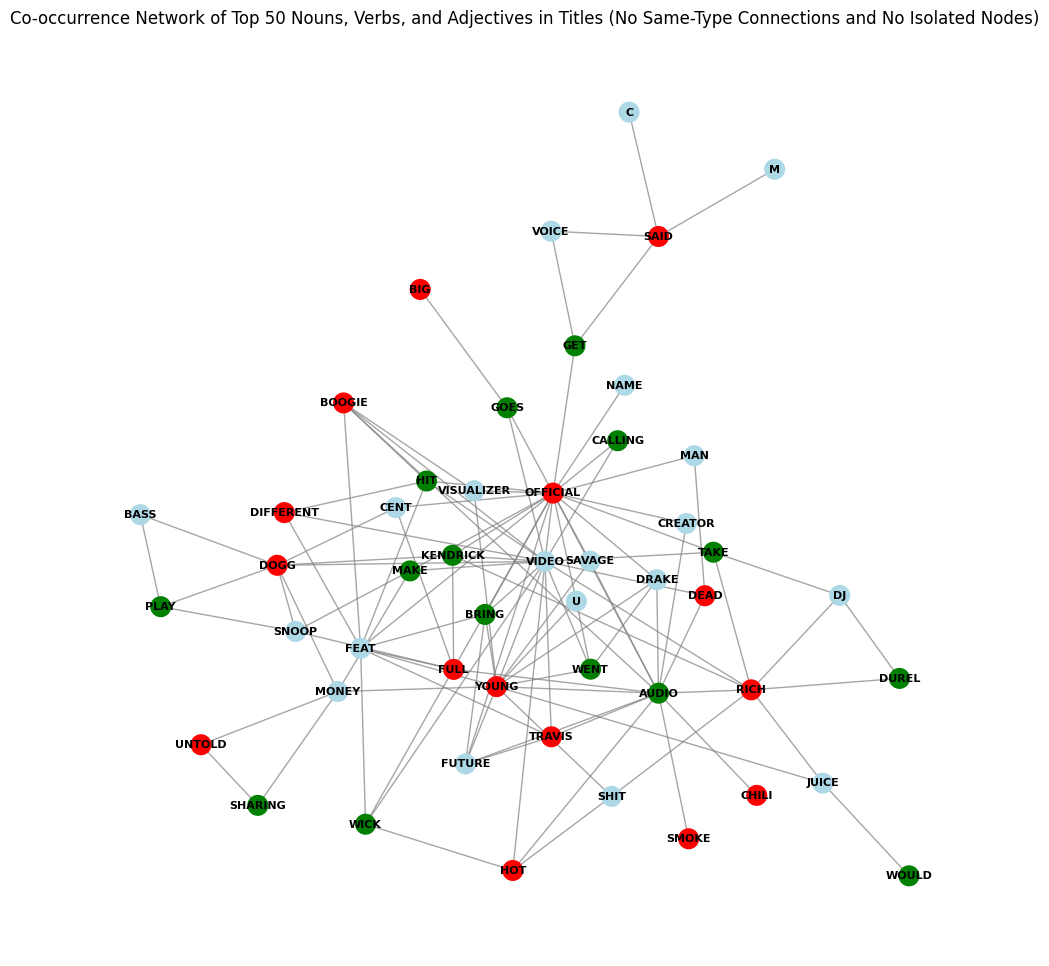

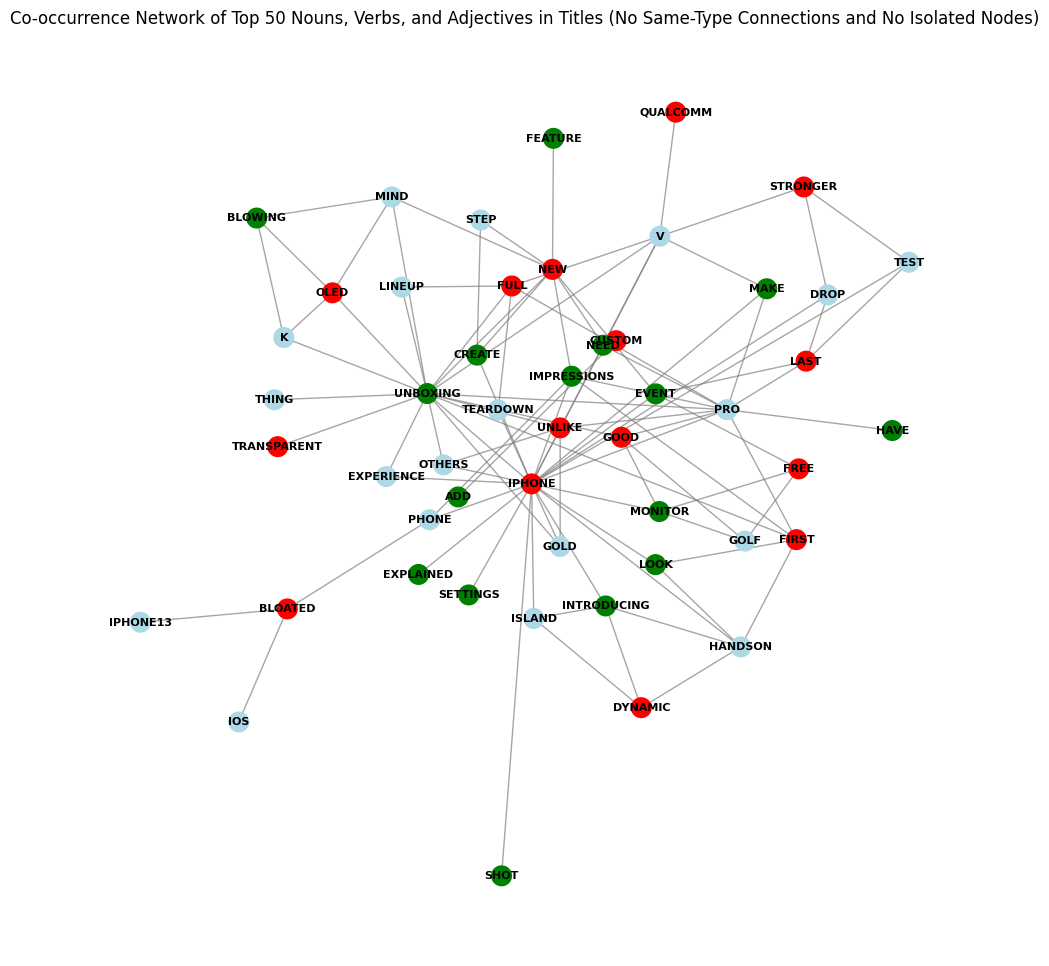

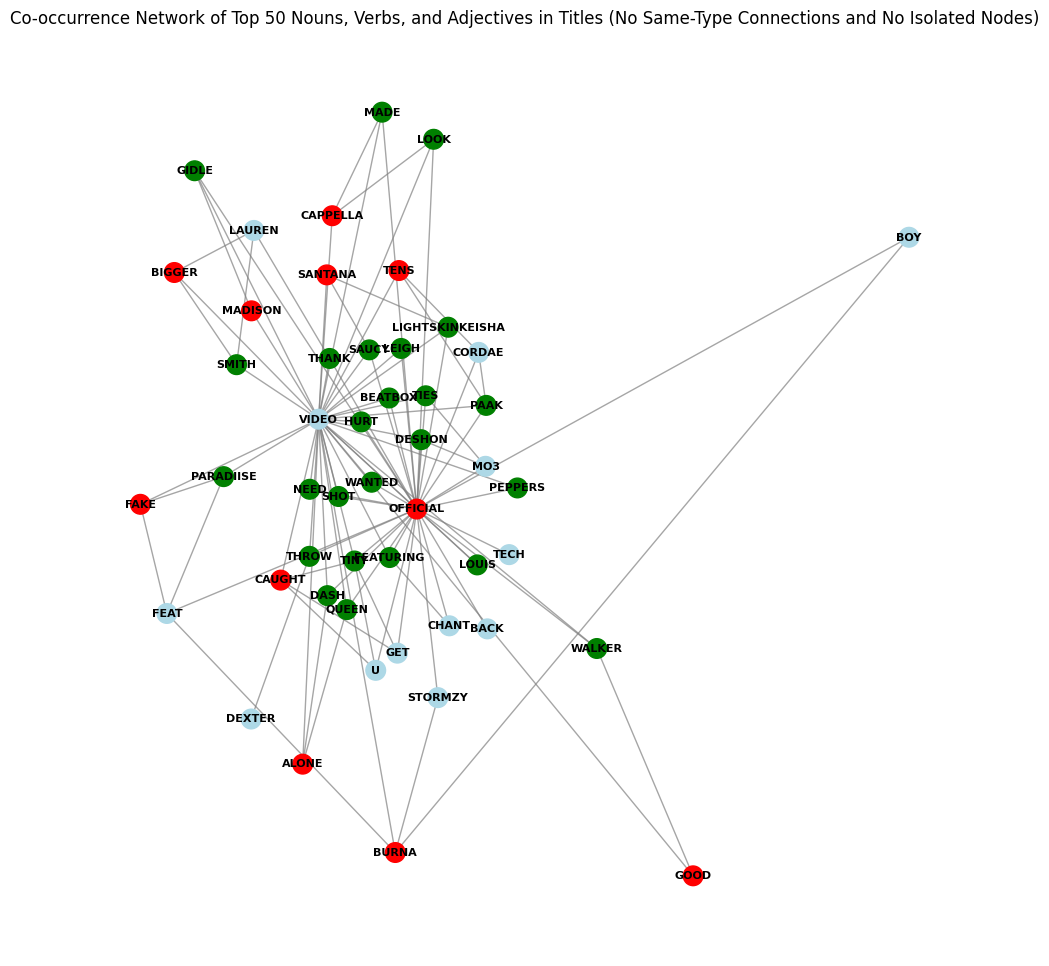

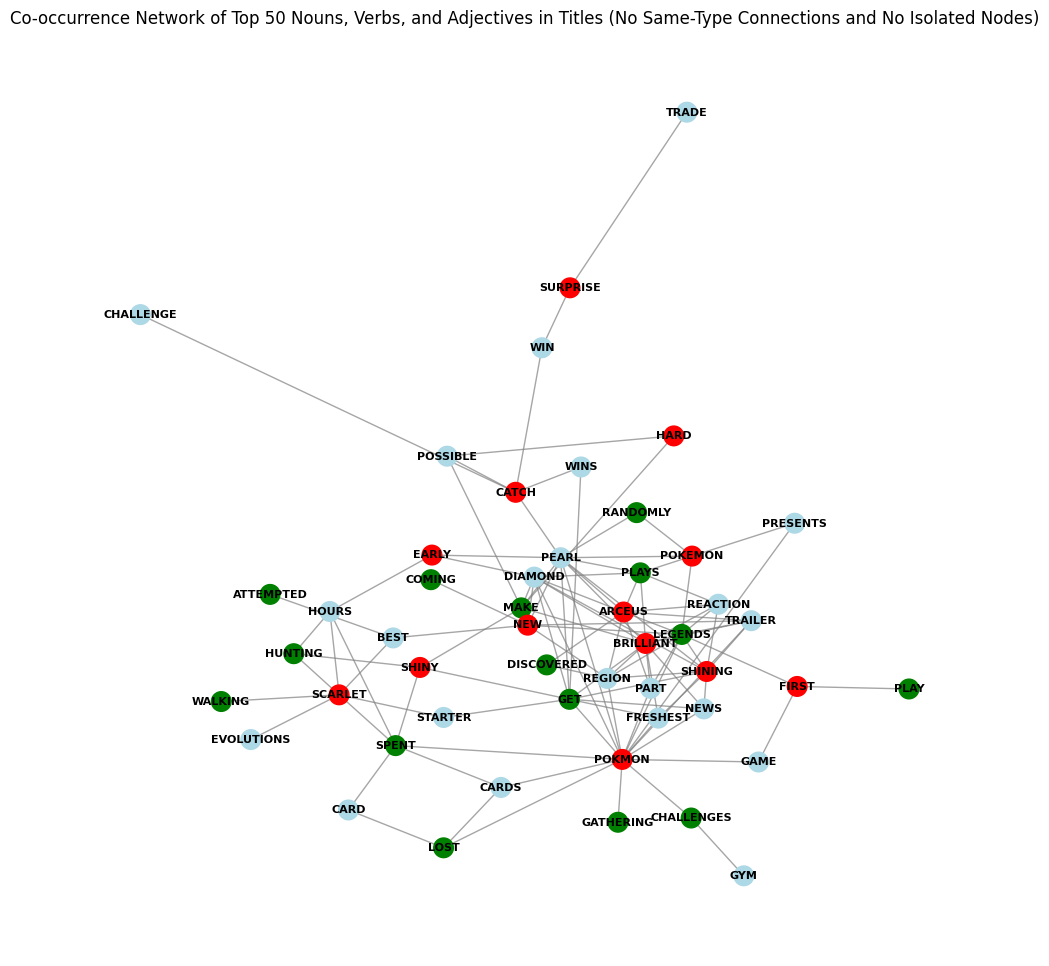

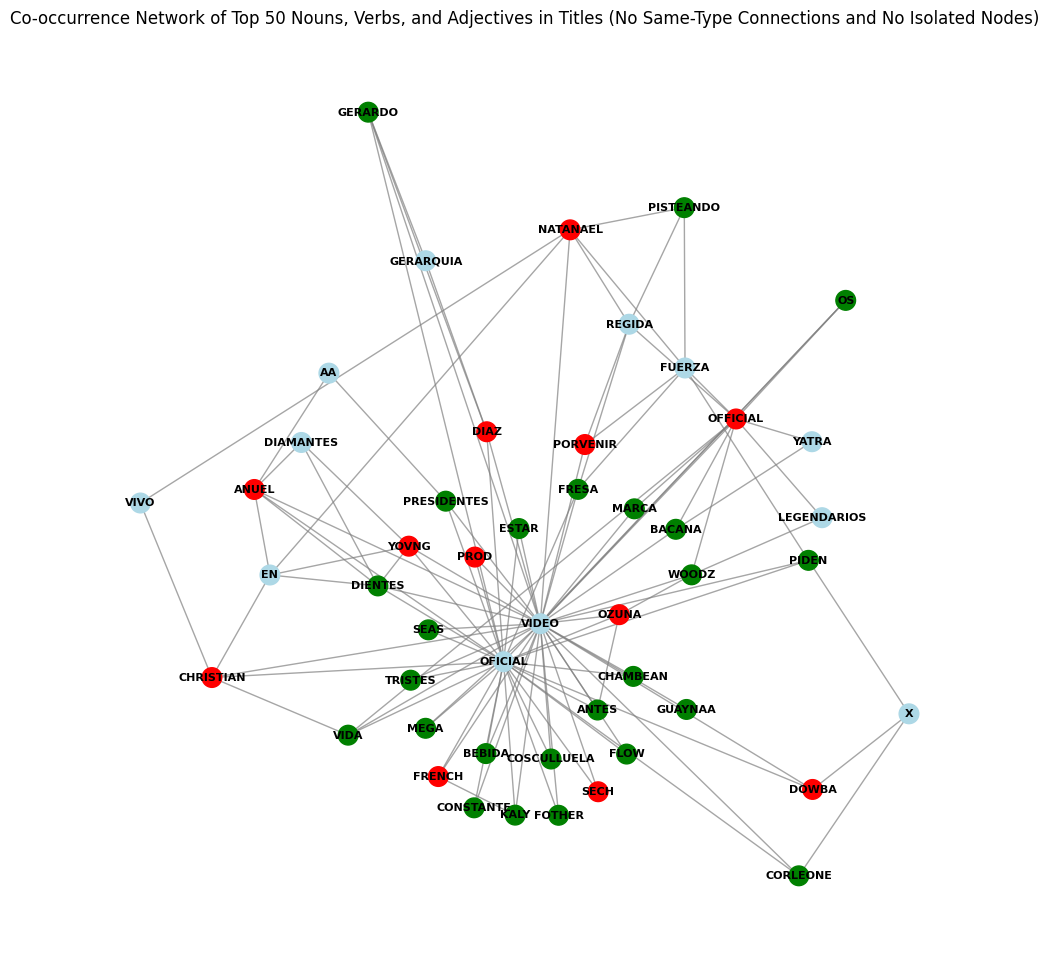

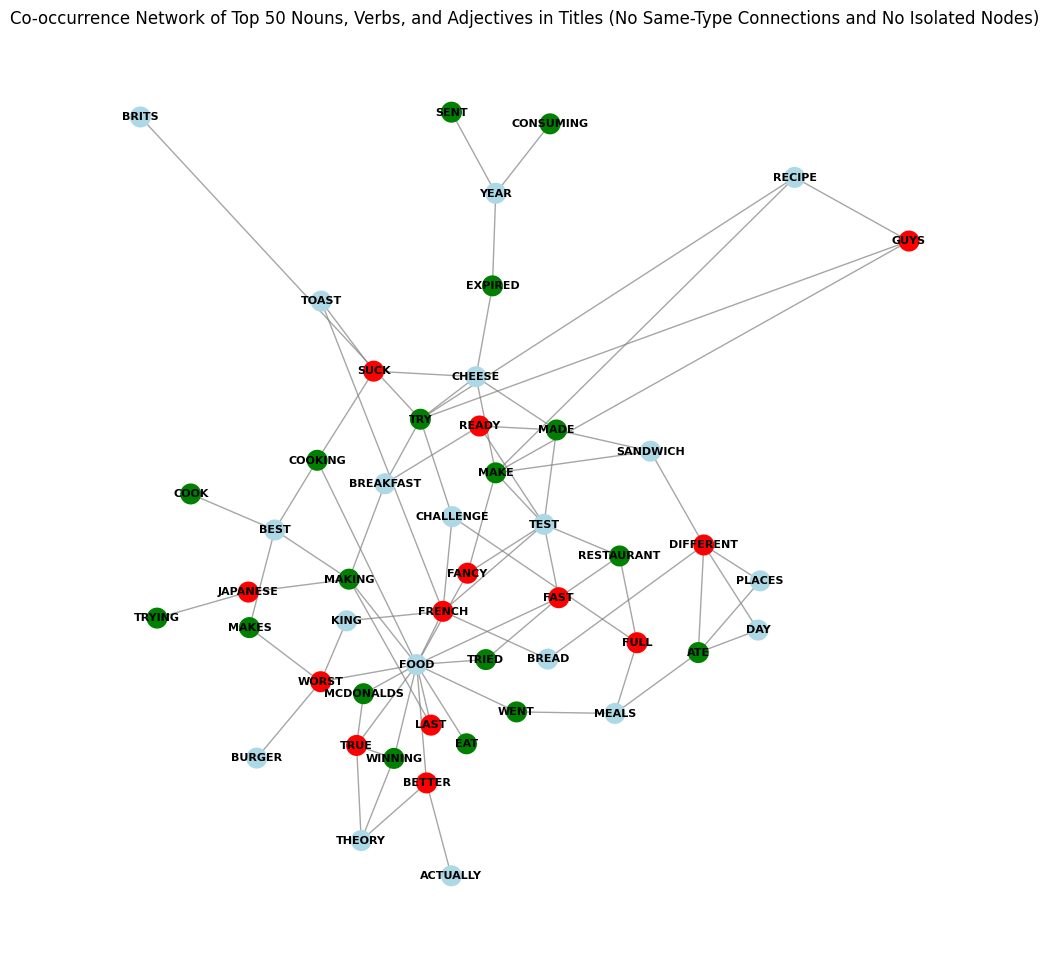

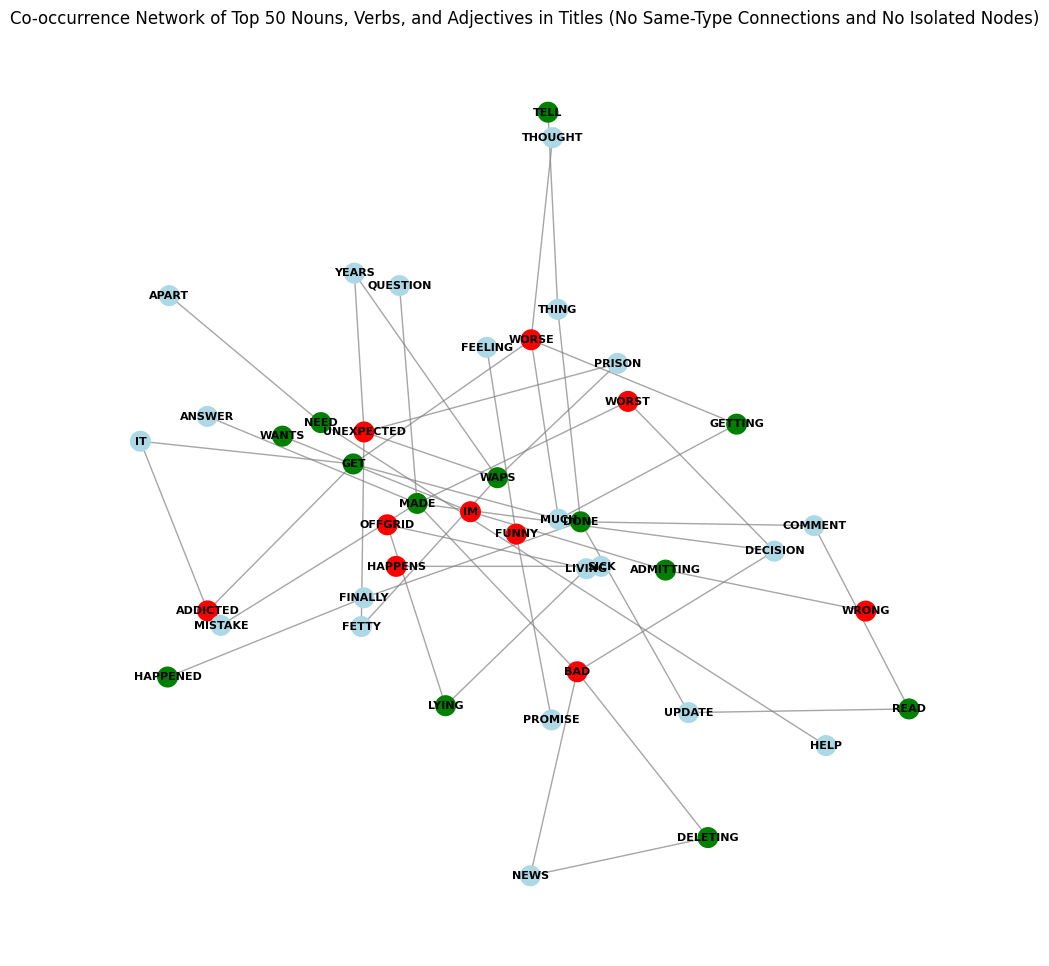

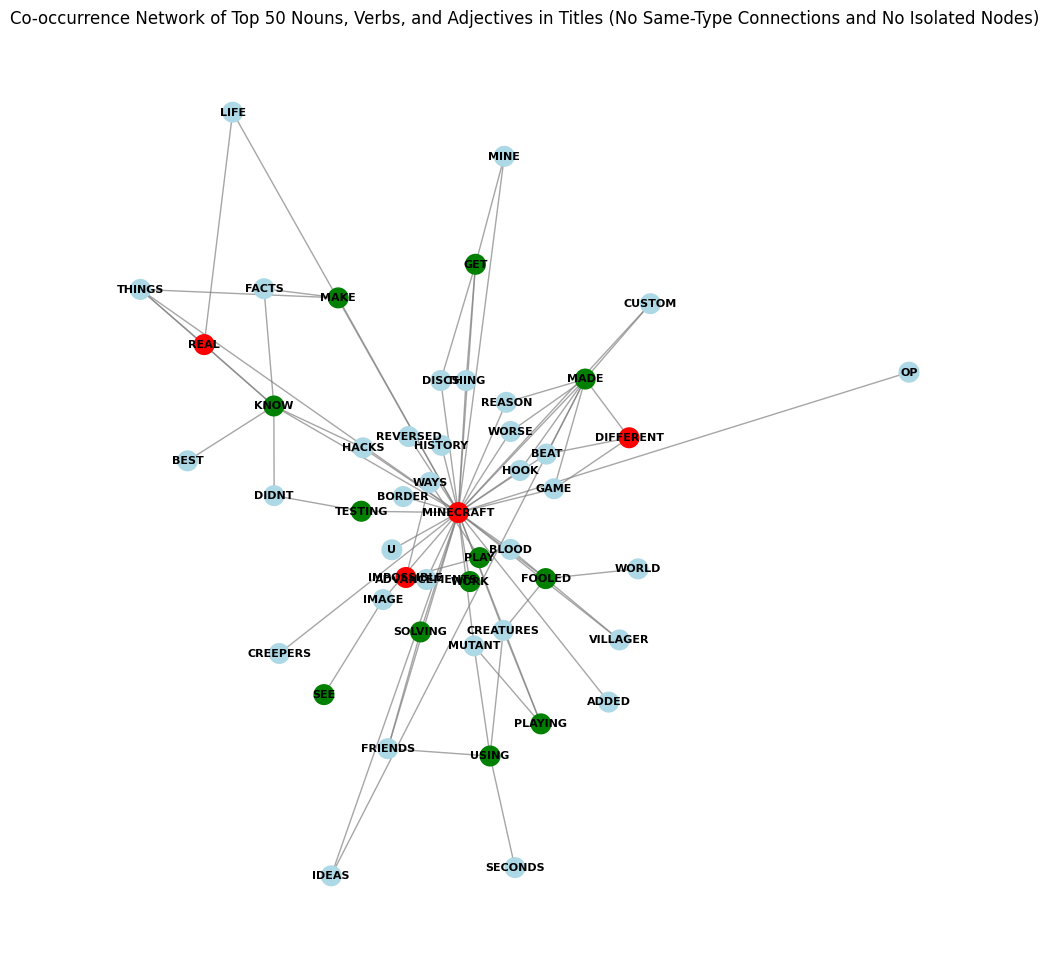

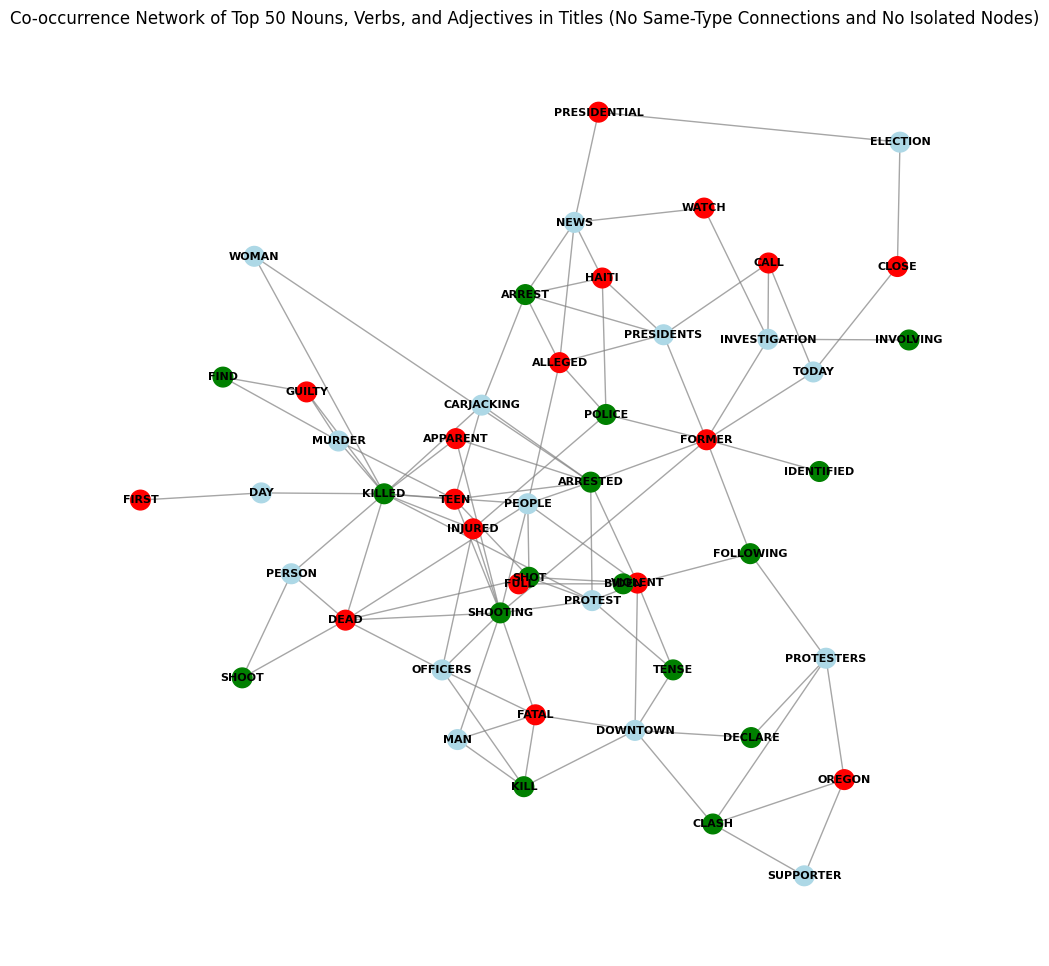

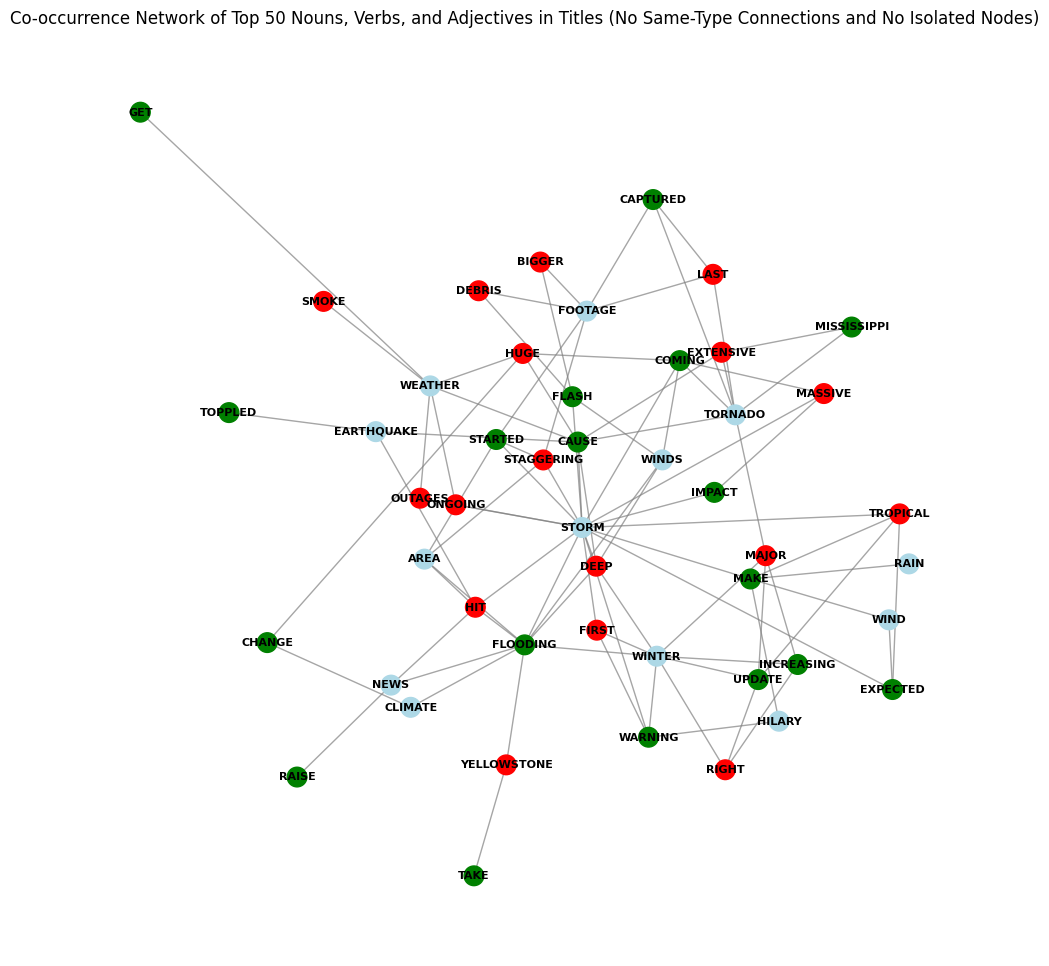

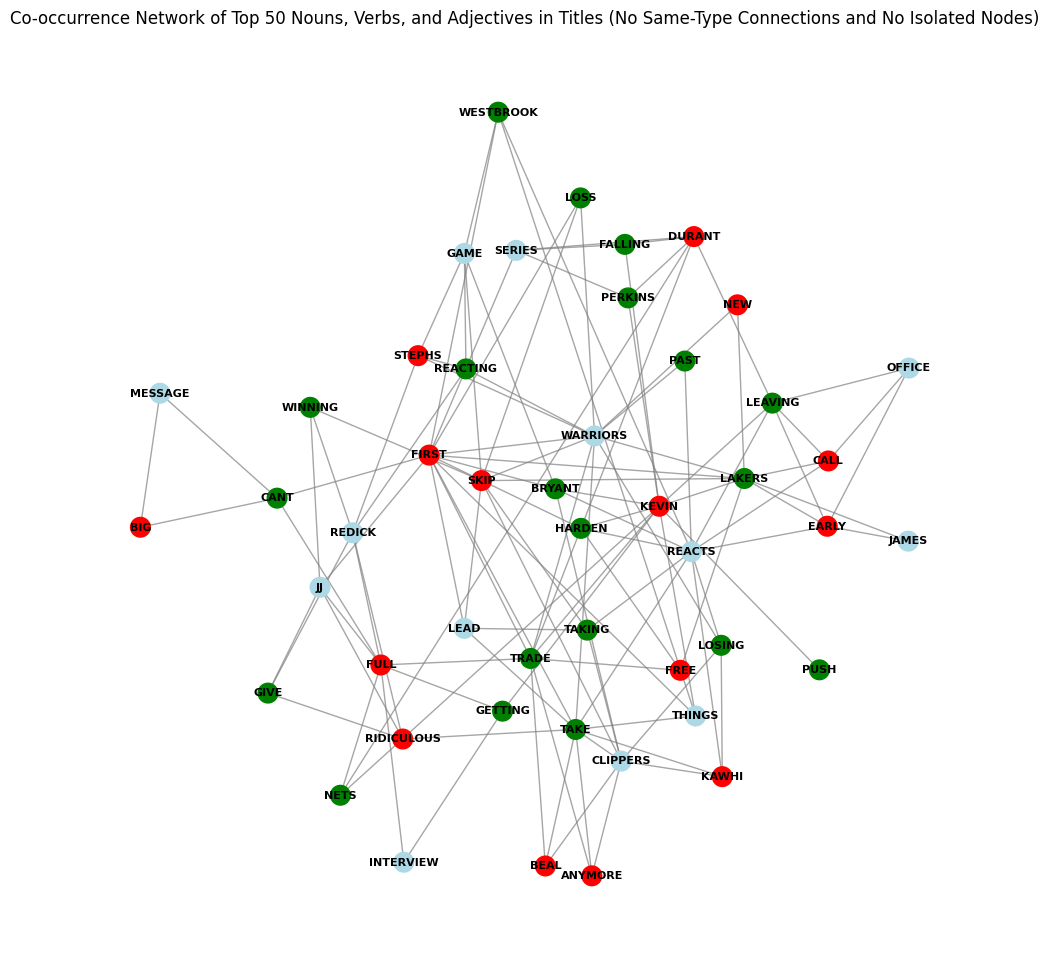

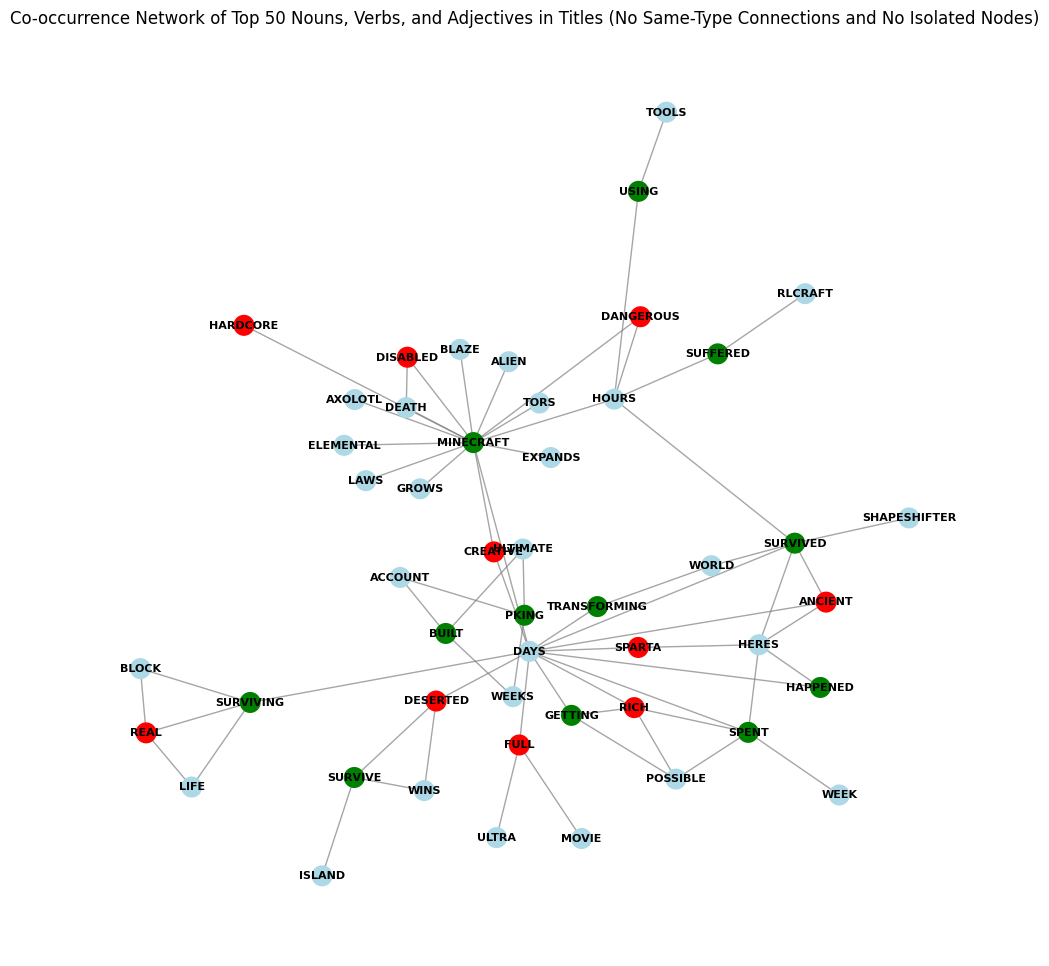

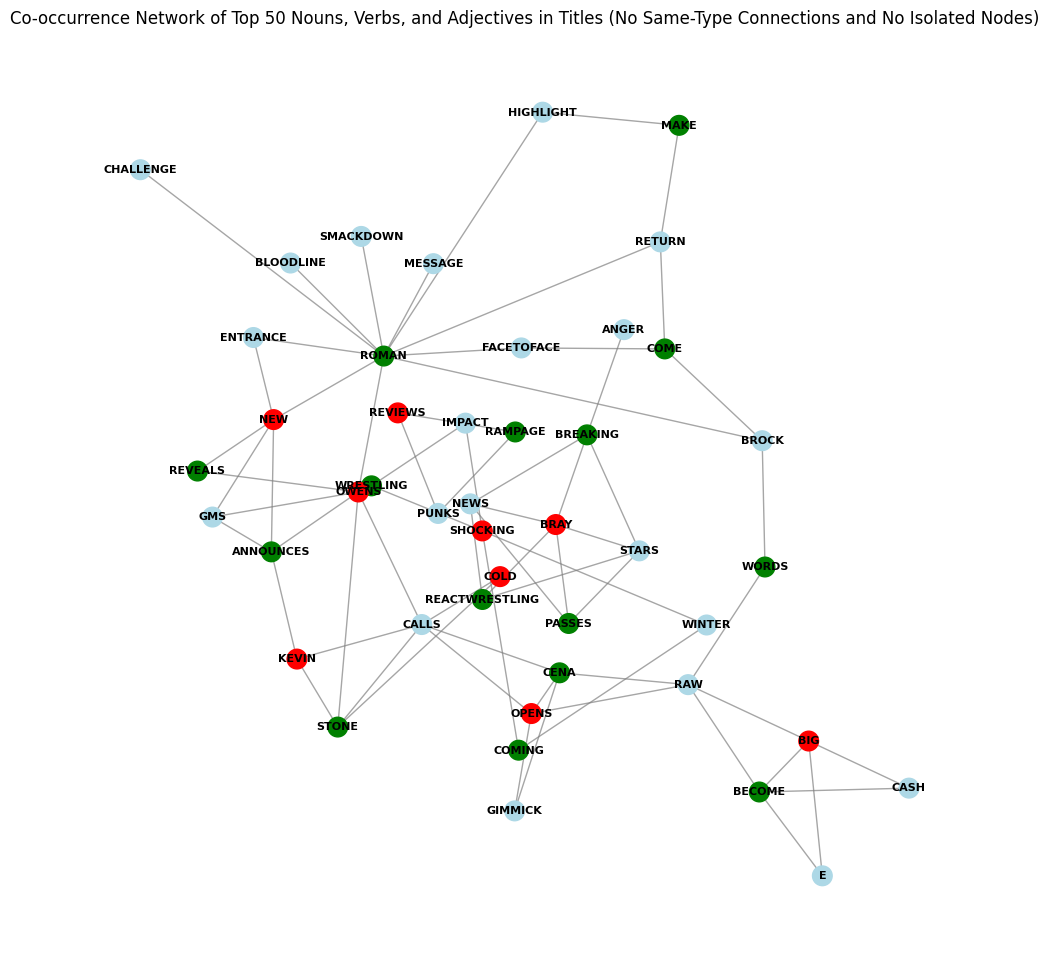

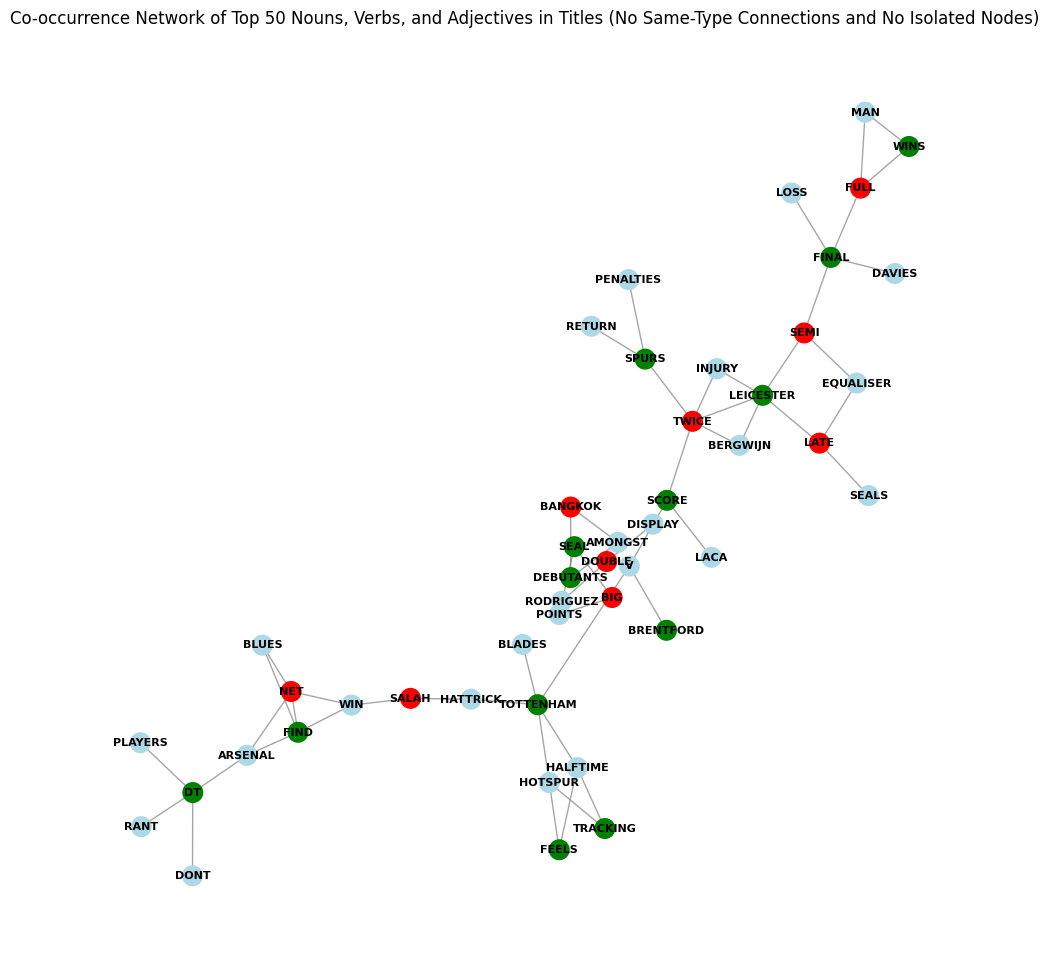

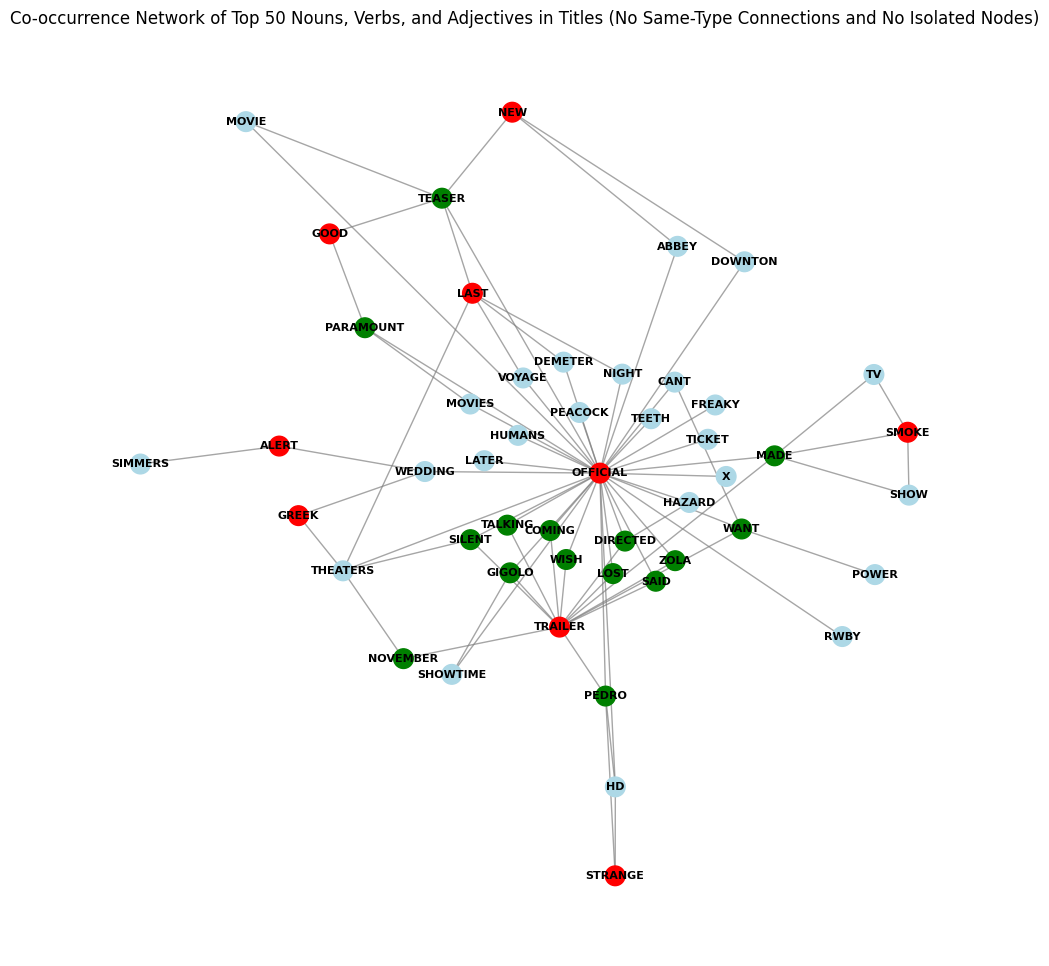

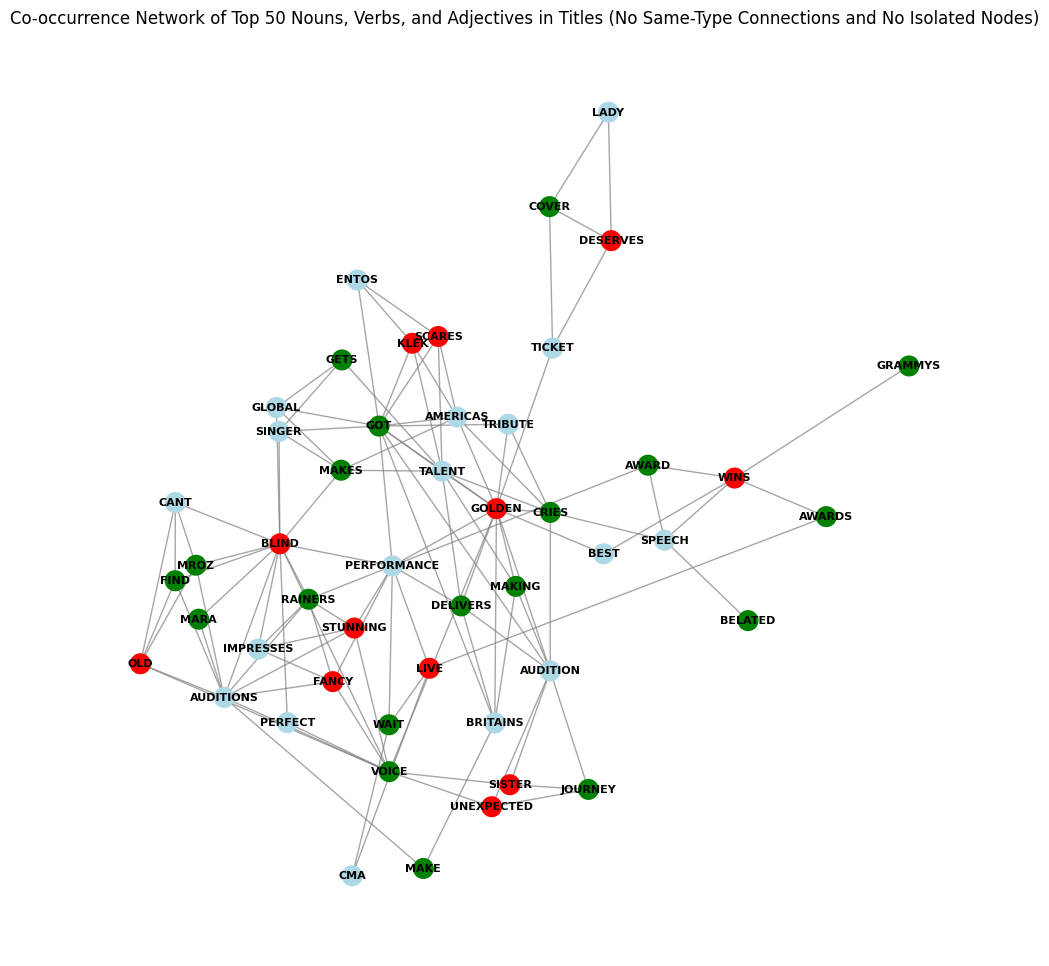

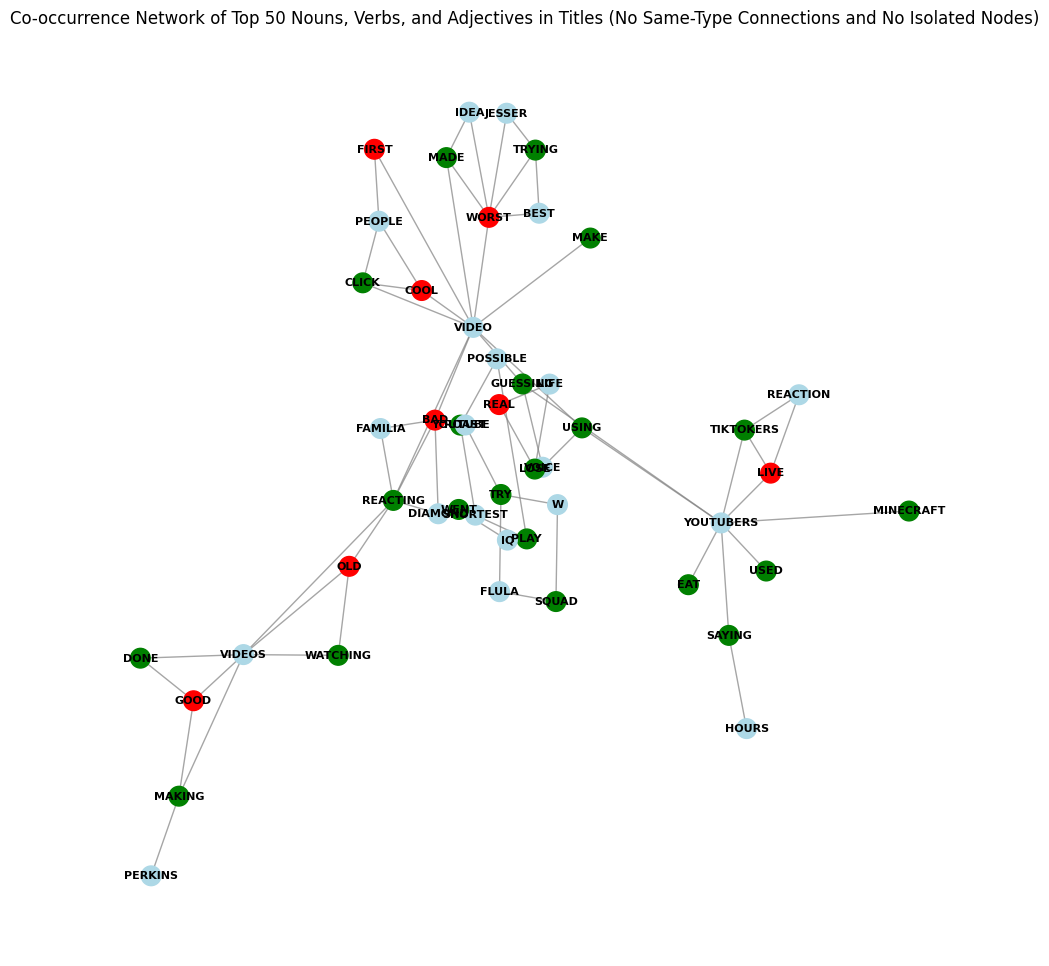

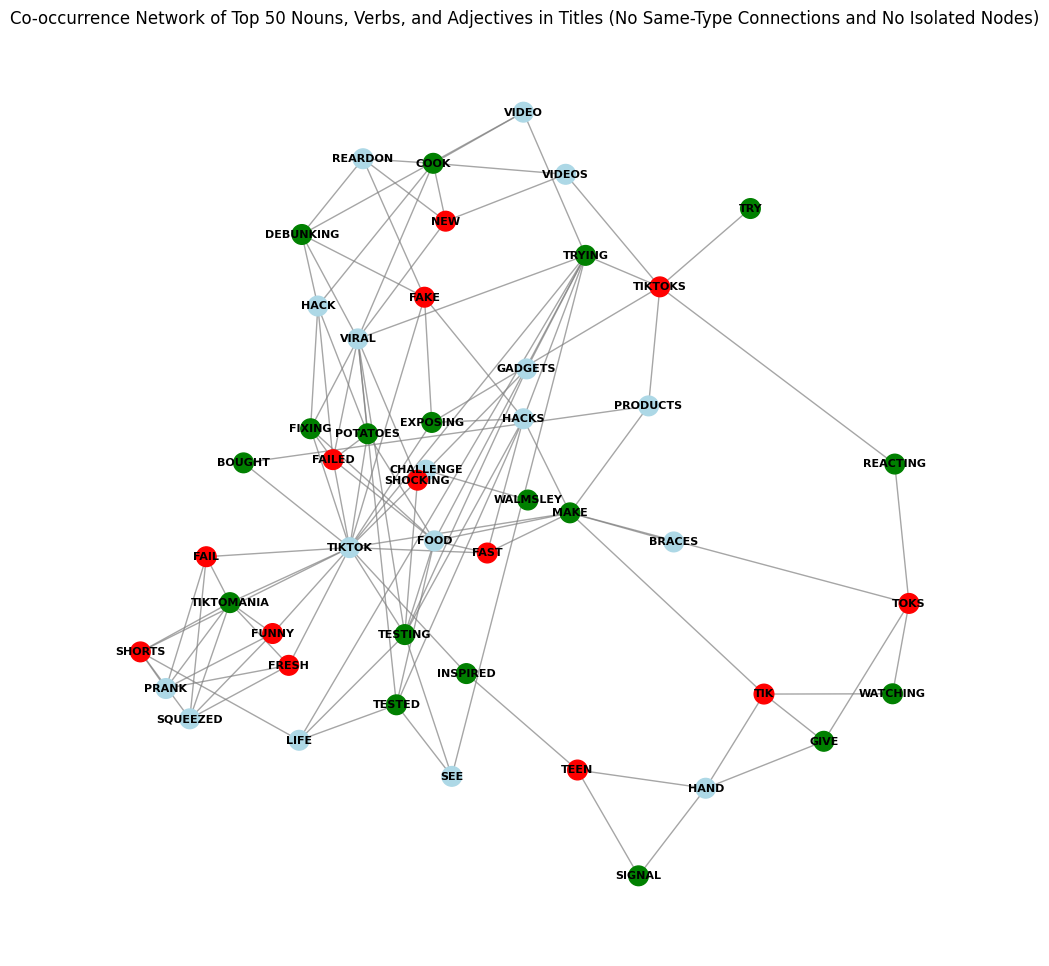

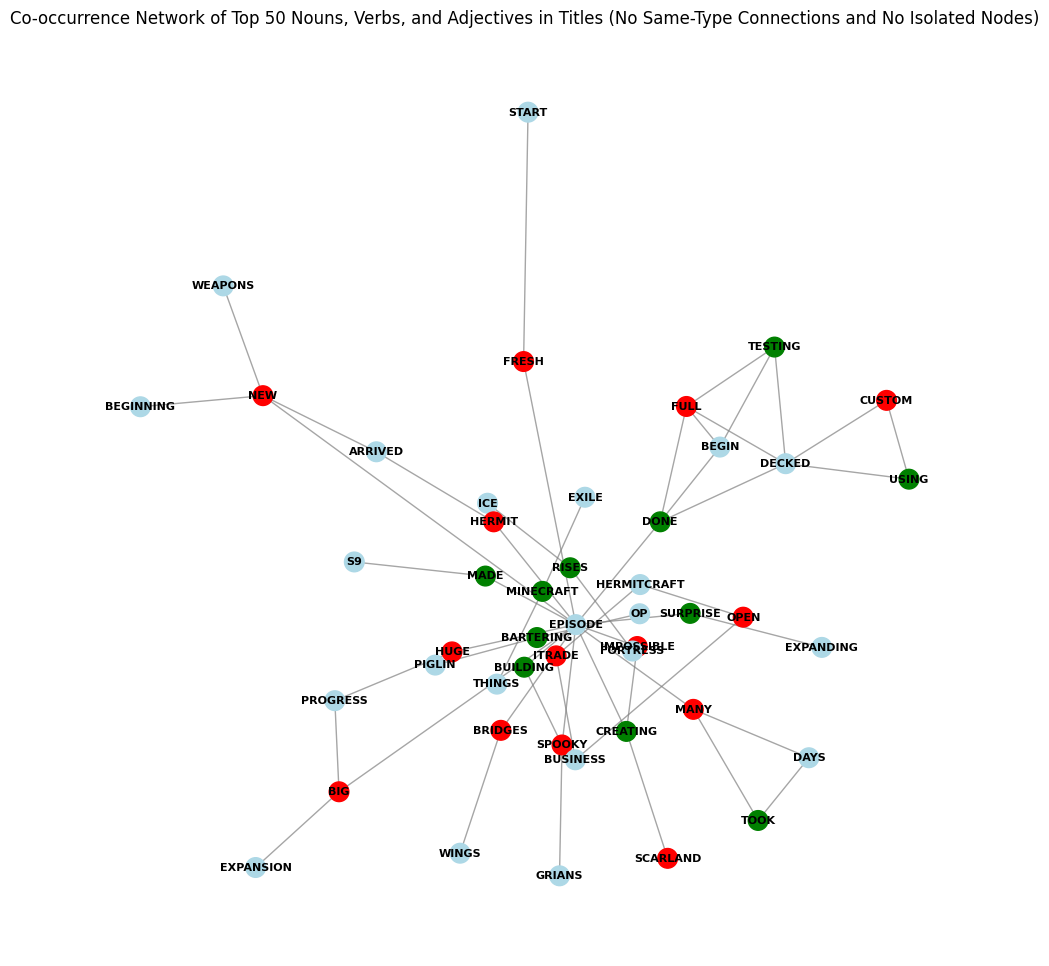

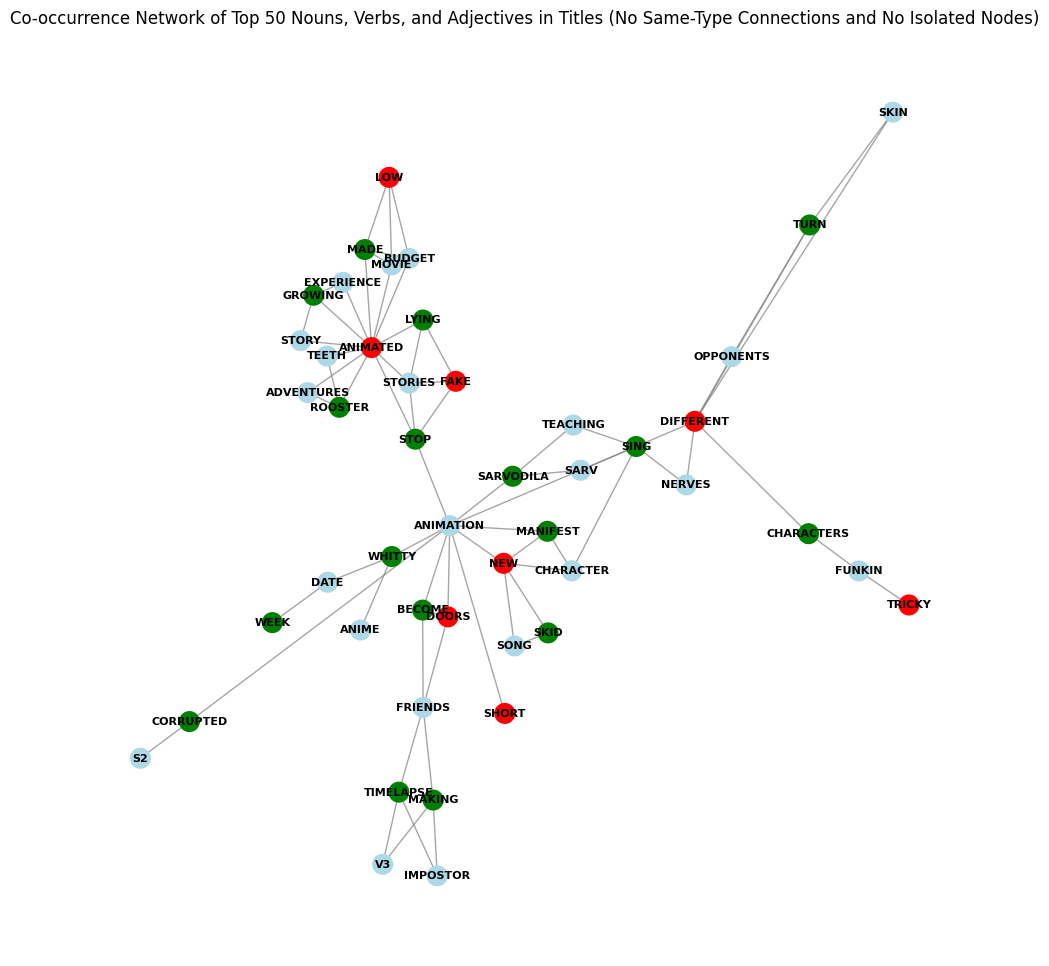

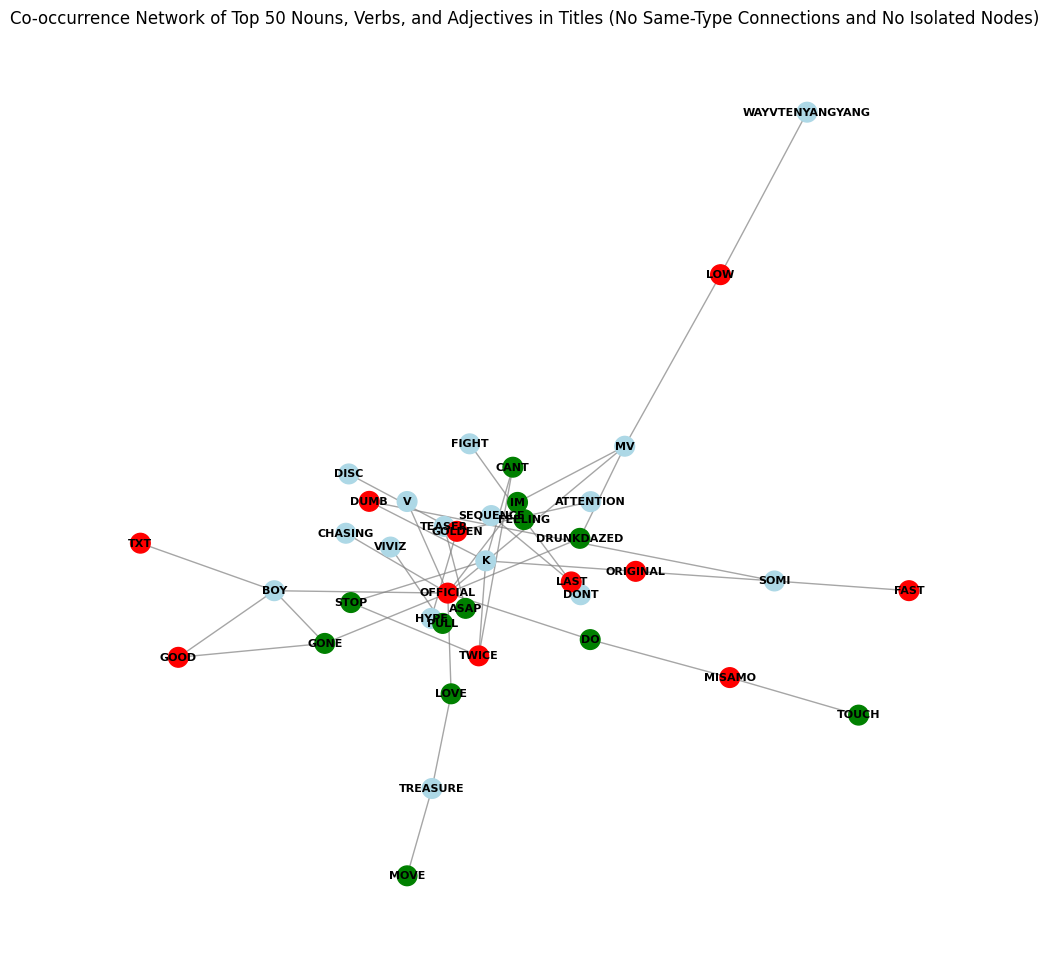

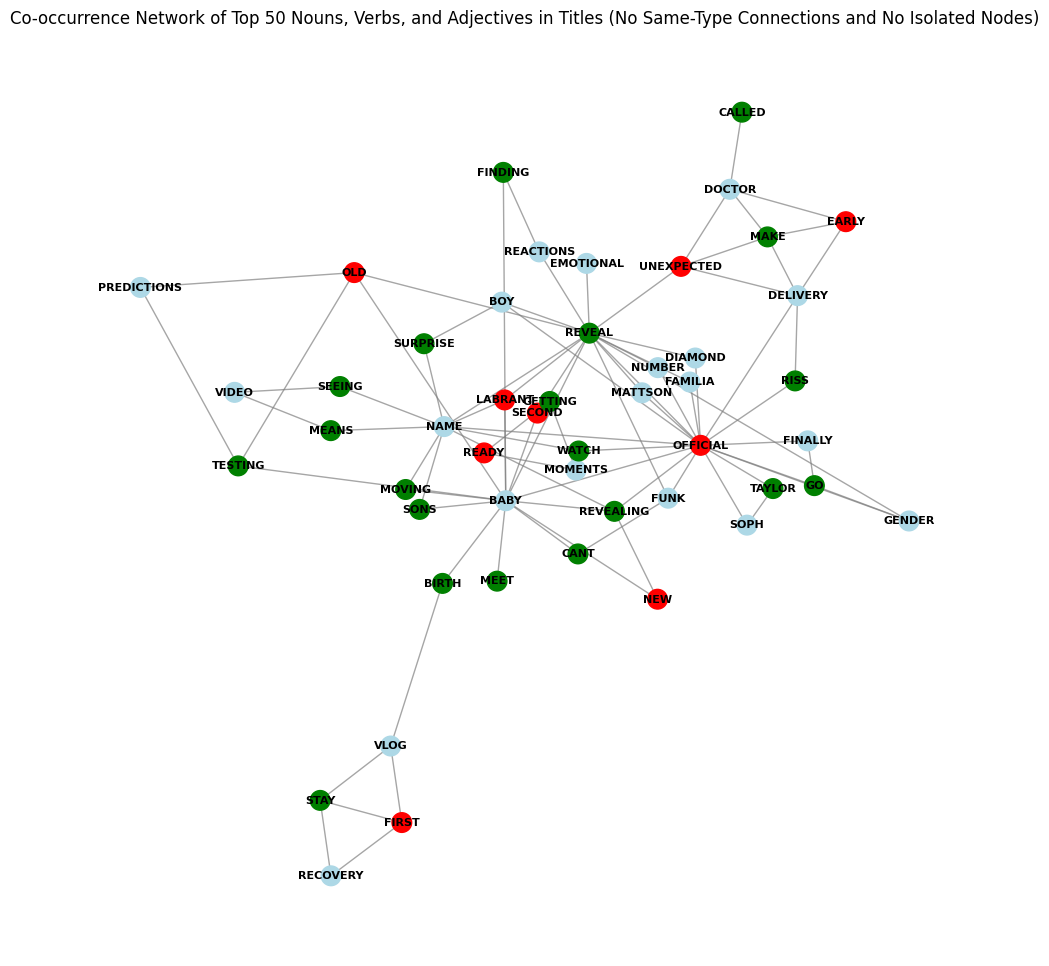

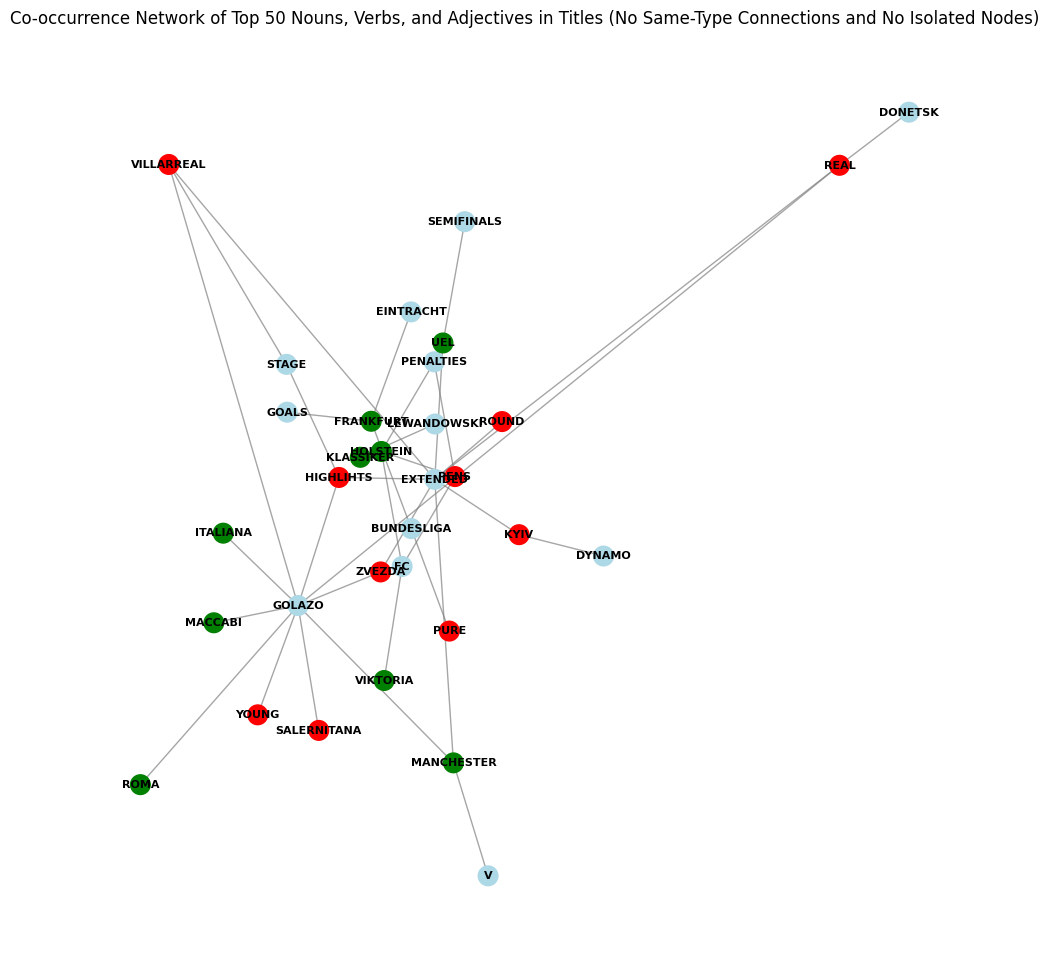

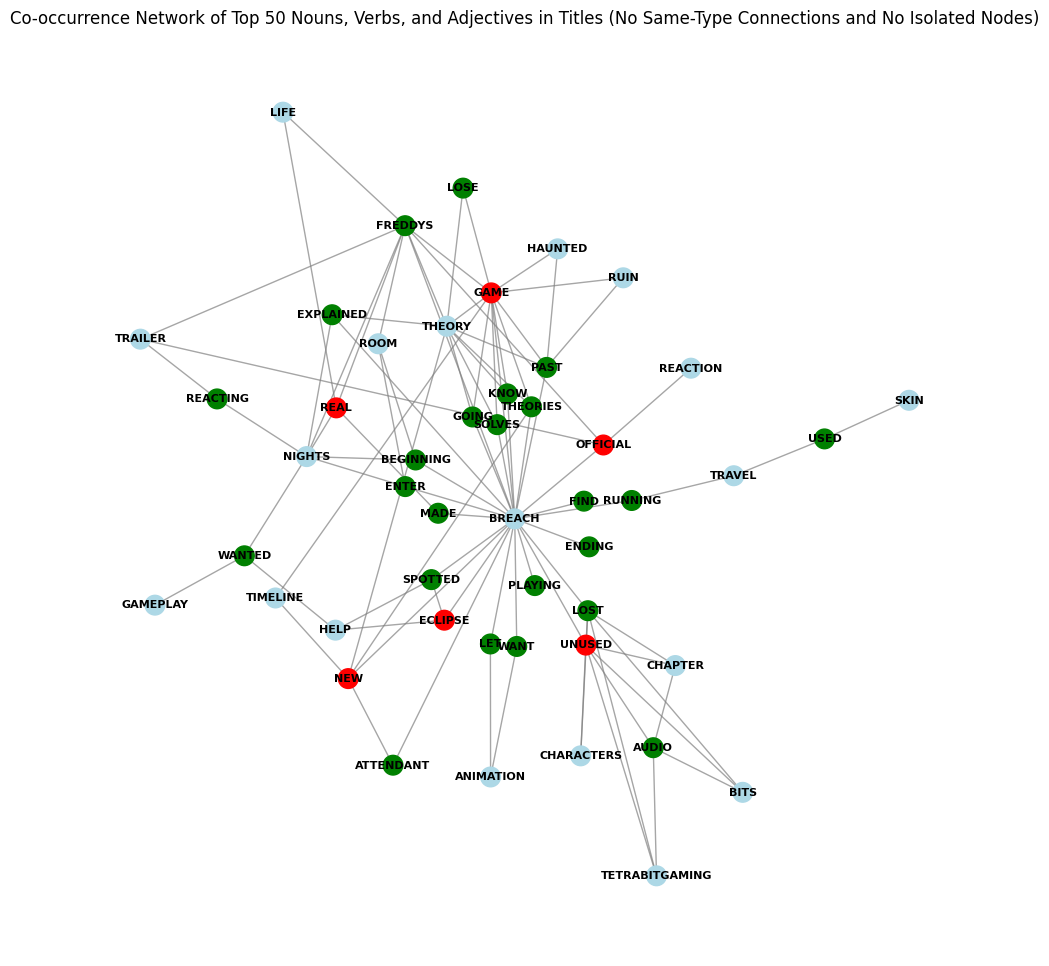

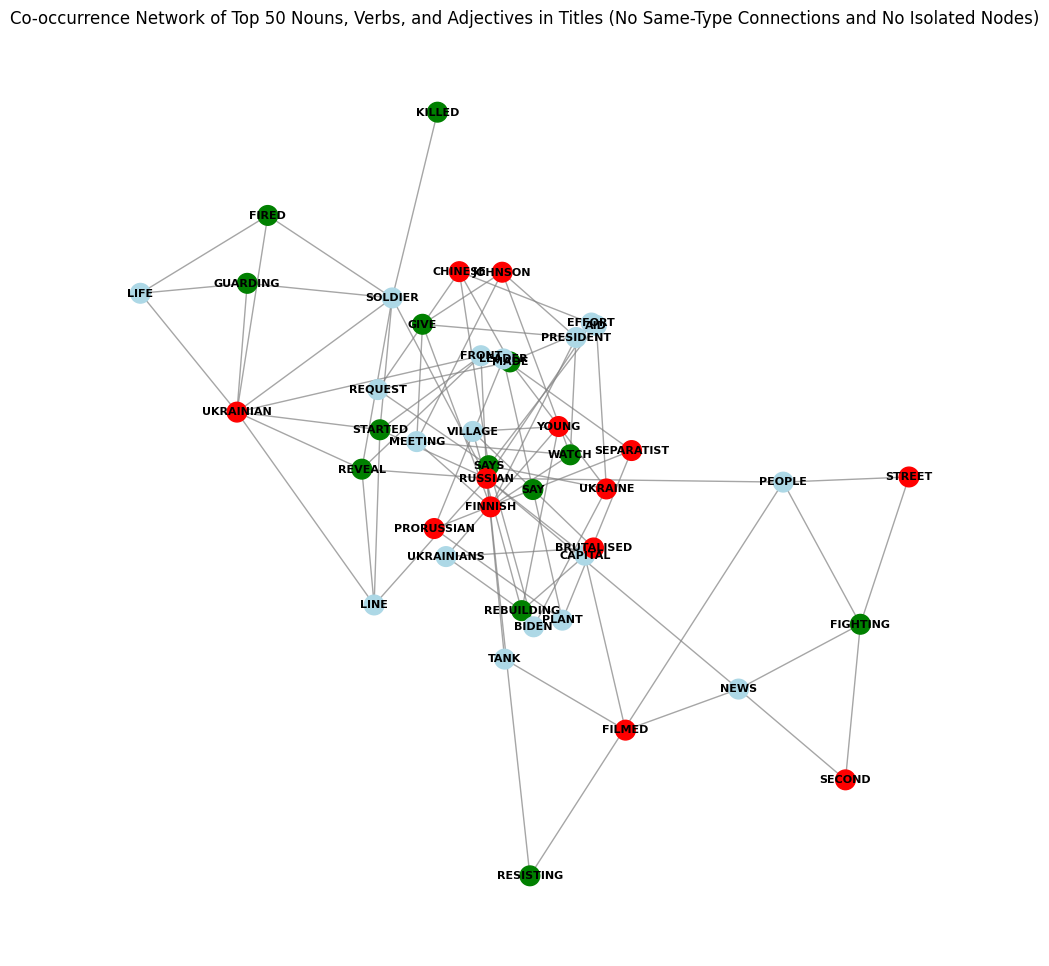

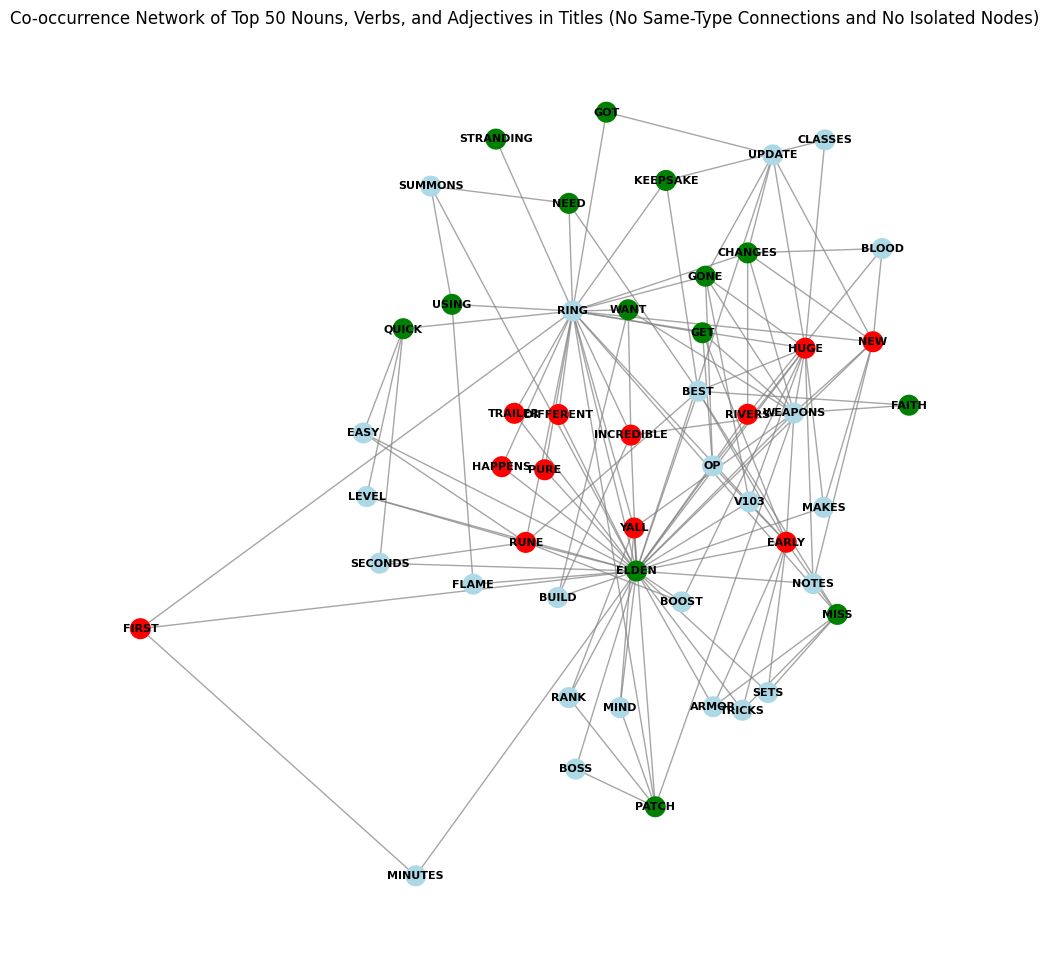

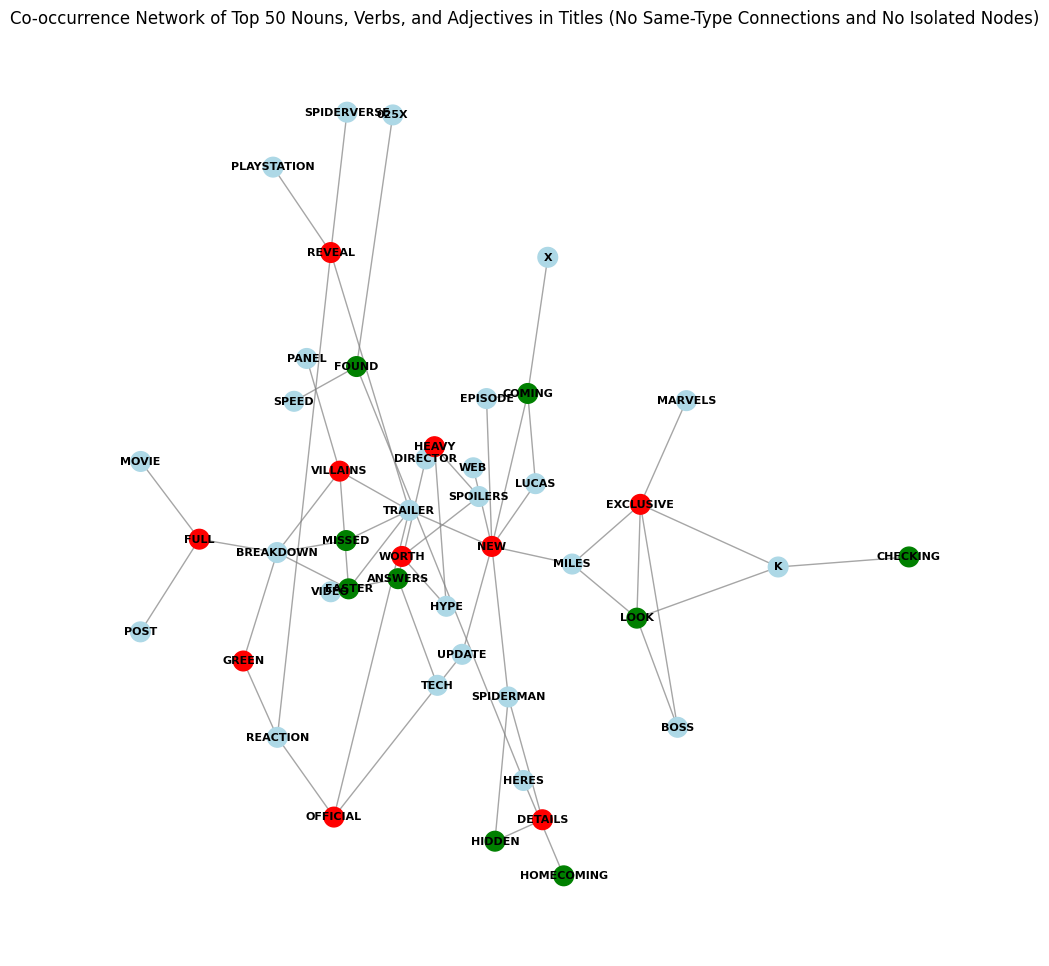

In [18]:
if __name__ == "__main__":
    node_df,edge_df= all_topics(df)
    edge_df.to_csv(r'C:\Users\BK\OneDrive\Desktop\Masters_HW\Data_Viz\project\Data\Topic\edges_df.csv')
    node_df.to_csv(r'C:\Users\BK\OneDrive\Desktop\Masters_HW\Data_Viz\project\Data\Topic\node_df.csv')